In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
np.random.seed(123)

In [2]:
def no_groups_model(y, t, beta, gamma, mu):
    S, I, R = y
    dSdt = mu - beta*S*I - mu*S
    dIdt = beta*S*I - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    return dSdt, dIdt, dRdt

In [3]:
def no_groups_seasonal_model(y, t, beta_0, beta_aug, t_start, t_season, t_year, mu, gamma):
    S, I, R = y
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    dSdt = mu - beta*S*I - mu*S
    dIdt = beta*S*I - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    return dSdt, dIdt, dRdt

In [4]:
def two_groups_model(y, t, beta, mu_0, mu_1, gamma, l_0, nu):
    S_0, I_0, R_0, S_1, I_1, R_1 = y
    I_T = I_0 + I_1
    dS_0dt = nu - beta*S_0*I_T - mu_0*S_0 - l_0*S_0
    dI_0dt = beta*S_0*I_T - gamma*I_0 - mu_0*I_0 - l_0*I_0
    dR_0dt = gamma*I_0 - mu_0*R_0 - l_0*R_0
    dS_1dt = l_0*S_0 - mu_1*S_1 - beta*S_1*I_T
    dI_1dt = l_0*I_0 - mu_1*I_1 + beta*S_1*I_T - gamma*I_1
    dR_1dt = l_0*R_0 - mu_1*R_1 + gamma*I_1
    return [dS_0dt,dI_0dt,dR_0dt,dS_1dt,dI_1dt,dR_1dt]

In [5]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [6]:
def two_groups_seasonal_model(y, t, beta_0, beta_aug, t_start, t_season, t_year, mu_0, mu_1, gamma, l_0, nu):
    S_0, I_0, R_0, S_1, I_1, R_1 = y
    I_T = I_0 + I_1
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    dS_0dt = nu - beta*S_0*I_T - mu_0*S_0 - l_0*S_0
    dI_0dt = beta*S_0*I_T - gamma*I_0 - mu_0*I_0 - l_0*I_0
    dR_0dt = gamma*I_0 - mu_0*R_0 - l_0*R_0
    dS_1dt = l_0*S_0 - mu_1*S_1 - beta*S_1*I_T
    dI_1dt = l_0*I_0 - mu_1*I_1 + beta*S_1*I_T - gamma*I_1
    dR_1dt = l_0*R_0 - mu_1*R_1 + gamma*I_1
    return [dS_0dt,dI_0dt,dR_0dt,dS_1dt,dI_1dt,dR_1dt]

## No age groups SIR dynamics - seasonal 

In [7]:
beta_0 = 0.0*(1/7.0)
beta_aug = 3.0*(1/7.0)
t_start = 0 
t_season = 60
t_year = 365

mu= 1/(80*365.0)
gamma = 1/7.0

y0 = 0.9, 0.1, 0.0
t = np.linspace(0, 365*20, 365*20)


ret = odeint(no_groups_seasonal_model, y0, t, args=(beta_0, beta_aug, t_start, t_season, t_year, mu, gamma))

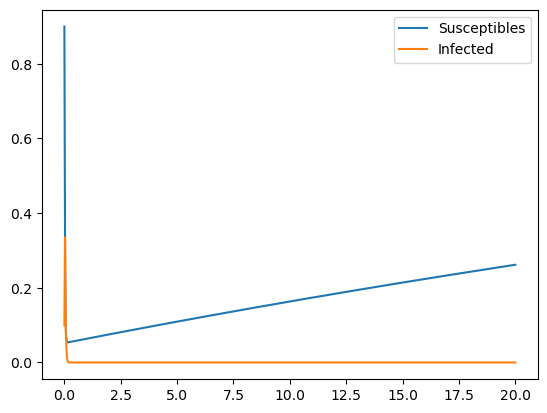

In [8]:
plt.plot(t/365,ret[:,0], label = 'Susceptibles')
plt.plot(t/365,ret[:,1], label = 'Infected')
plt.legend()

## Two age groups SIR dynamics

- $\nu$ has to be high enough to have new outbreaks, which in this case means $l_0$ has to be high enough or $\alpha$ as well
- $\beta$ has to be high enough as well for this to be favorable

In [15]:
alpha = 0.25
beta = 3*(1/7.0) 
mu_0 = 0.0
gamma = 1/(7.0)
l_0 = 1/(1*365)
nu = (l_0 + mu_0)*(alpha)
mu_1 = (l_0*(alpha))/(1-alpha)

y0 = alpha, 0.0, 0.0, 1-alpha-0.1, 0.1, 0.0
t = np.linspace(0, 365*20, 365*20)

In [16]:
ret = odeint(two_groups_model, y0, t, args=(beta, mu_0, mu_1, gamma, l_0, nu))

In [19]:
ret[:,1]

array([0.        , 0.01100506, 0.02254068, ..., 0.00170901, 0.00170883,
       0.00170866])

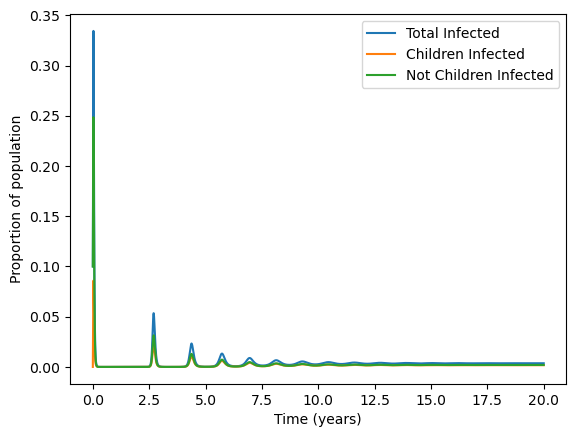

In [18]:
plt.plot(t/365,ret[:,1]+ret[:,4], label = 'Total Infected')
plt.plot(t/365, ret[:,1], label = 'Children Infected')
plt.plot(t/365,ret[:,4], label = 'Not Children Infected')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of population')
plt.legend()
plt.show()

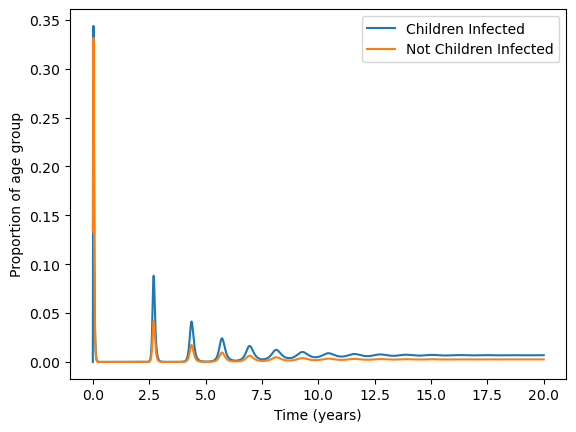

In [12]:
plt.plot(t/365, ret[:,1]/alpha, label = 'Children Infected')
plt.plot(t/365,ret[:,4]/(1-alpha), label = 'Not Children Infected')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of age group')
plt.legend()
plt.show()

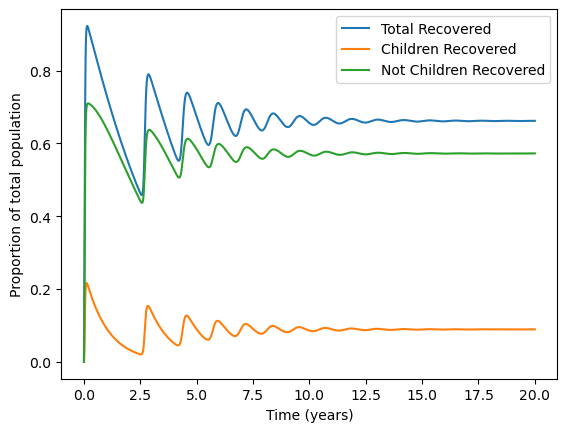

In [13]:
plt.plot(t/365,ret[:,2]+ret[:,5], label = 'Total Recovered')
plt.plot(t/365, ret[:,2], label = 'Children Recovered')
plt.plot(t/365,ret[:,5], label = 'Not Children Recovered')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of total population')
plt.legend()
plt.show()

In [14]:
IT = ret[:,1] + ret[:,4]
prop_0_year = []
prop_1_year = []

for i in range(20):
    total_cases = sum(ret[i*365:(i+1)*365,1]) + sum(ret[i*365:(i+1)*365,4])
    prop_0_year.append(sum(ret[i*365:(i+1)*365,1])/(alpha*total_cases))
    prop_1_year.append(sum(ret[i*365:(i+1)*365,4])/((1-alpha)*total_cases))

Text(0, 0.5, 'Age Group Rate')

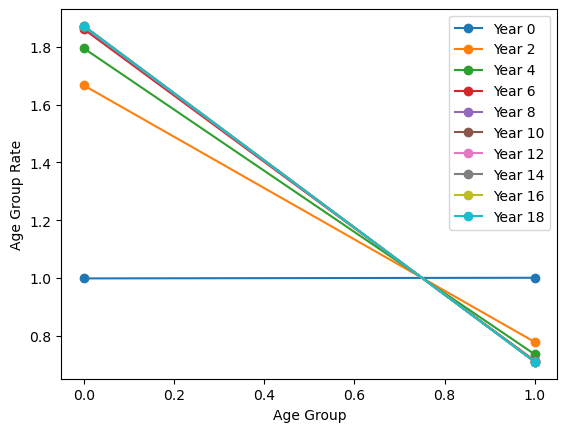

In [15]:
for i in range(10):
    plt.plot([0,1],[prop_0_year[2*i], prop_1_year[2*i]], '-o', label = 'Year '+str(2*i))
plt.legend()
plt.xlabel('Age Group')
plt.ylabel('Age Group Rate')

## Two age groups SIR dynamics with seasonality

In [16]:
beta_0 = 0.0 
beta_aug = 3*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365

alpha = 0.25
mu_0 = 0.0
gamma = 0.10
l_0 = 1/(1*365)
nu = (l_0 + mu_0)*(alpha)
mu_1 = (l_0*(alpha))/(1-alpha)

y0 = alpha, 0.0, 0, 1-alpha-0.1, 0.1, 0
t = np.linspace(0, 365*5, 365*5)

In [17]:
ret = odeint(two_groups_seasonal_model, y0, t, args=(beta_0, beta_aug, t_start, t_season, t_year, mu_0, mu_1, gamma, l_0, nu))

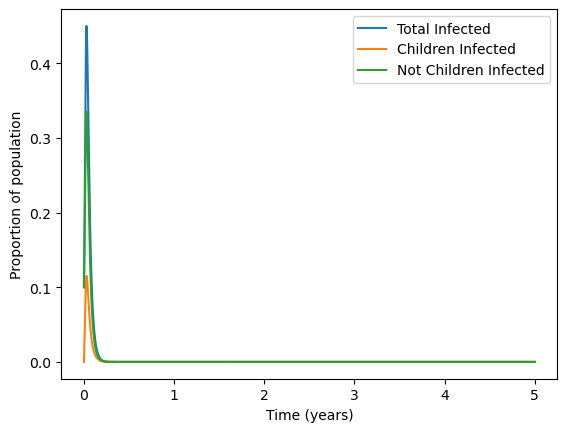

In [18]:
plt.plot(t/365,ret[:,1]+ret[:,4], label = 'Total Infected')
plt.plot(t/365, ret[:,1], label = 'Children Infected')
plt.plot(t/365,ret[:,4], label = 'Not Children Infected')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of population')
plt.legend()

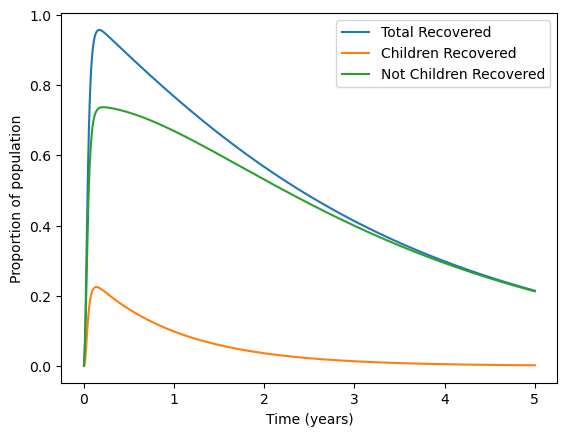

In [19]:
plt.plot(t/365,ret[:,2]+ret[:,5], label = 'Total Recovered')
plt.plot(t/365, ret[:,2], label = 'Children Recovered')
plt.plot(t/365,ret[:,5], label = 'Not Children Recovered')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of population')
plt.legend()
plt.show()

## Two age groups SIR dynamics with seasonality and deterministic reintroduction

In [20]:
seasons = 20
t_single_season = np.arange(0,365,1) 
t_total_season = np.arange(0,365*20,1)
I_0_season = []
I_1_season = []

beta_0 = 0.0
beta_aug = 3*(1/10.0) # report with 6 as well
t_start = 0 
t_season = 60
t_year = 365
prop_imported = 0.05

y0 = alpha, 0.0, 0, 1-alpha-0.1, 0.1, 0

alpha = 0.12
mu_0 = 0.0
gamma = 1/(10.0)
l_0 = 1/(10*365)
nu = (l_0 + mu_0)*(alpha)
mu_1 = (l_0*(alpha))/(1-alpha)

In [21]:
def modify_initial_condition(y0, prop_imported):
    y0_aux = y0.copy()
    y0[1] = y0_aux[1] - y0_aux[1]*prop_imported 
    y0[2] = y0_aux[2] + y0_aux[1]*prop_imported
    y0[3] = y0_aux[3] - y0_aux[3]*prop_imported
    y0[4] = y0_aux[4] + y0_aux[3]*prop_imported 
    return y0

In [22]:
for season in np.arange(seasons):
    ret = odeint(two_groups_seasonal_model, y0, t_single_season, args=(beta_0, beta_aug, t_start, t_season, t_year, mu_0, mu_1, gamma, l_0, nu))
    I_0_season.append(list(ret[:,1]))
    I_1_season.append(list(ret[:,4]))
    y0 = ret[-1,:].copy()
    num = 0.05
    y0 = modify_initial_condition(y0,num)

In [23]:
I_0_season = [item for sublist in I_0_season for item in sublist]
I_1_season = [item for sublist in I_1_season for item in sublist]

Text(0, 0.5, 'Proportion in Population')

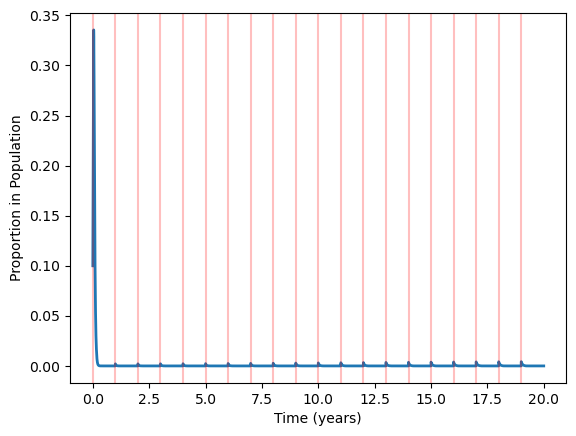

In [24]:
plt.plot(t_total_season/365,np.array(I_0_season) + np.array(I_1_season), linewidth = 2)
for season in np.arange(seasons):
    plt.axvline(season, color = 'r', alpha = 0.25)
plt.xlabel('Time (years)')
plt.ylabel('Proportion in Population')

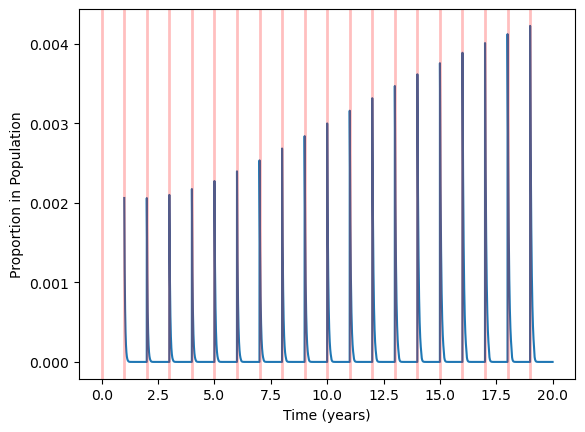

In [25]:
plt.plot(t_total_season[365:]/365,np.array(I_0_season)[365:] + np.array(I_1_season)[365:])
for season in np.arange(seasons):
    plt.axvline(season, color = 'r', alpha = 0.25, linewidth = 2)
plt.xlabel('Time (years)')
plt.ylabel('Proportion in Population')
plt.show()

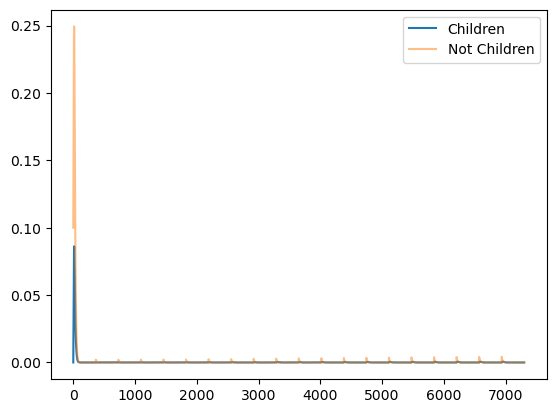

In [26]:
plt.plot(np.array(I_0_season), label = 'Children')
plt.plot(np.array(I_1_season), label = 'Not Children',alpha = 0.5)
plt.legend()

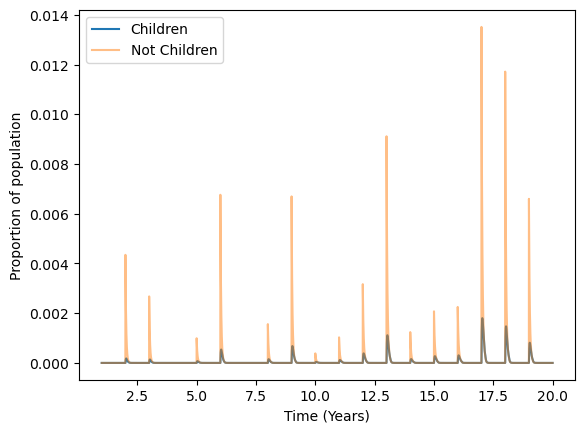

In [45]:
plt.plot(t_total_season[365:]/365,np.array(I_0_season)[365:], label = 'Children')
plt.plot(t_total_season[365:]/365,np.array(I_1_season)[365:], label = 'Not Children',alpha = 0.5)
plt.ylabel('Proportion of population')
plt.xlabel('Time (Years)')
plt.legend()

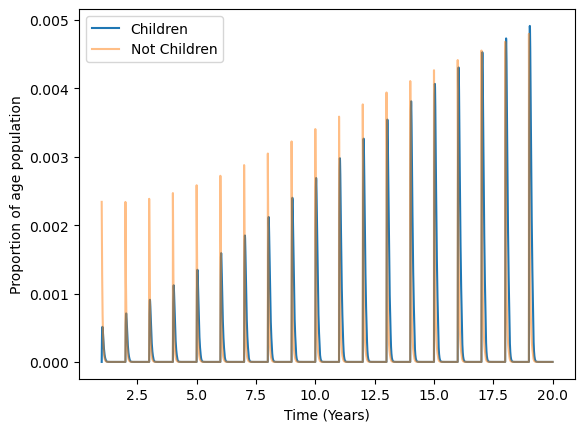

In [27]:
plt.plot(t_total_season[365:]/365,np.array(I_0_season)[365:]/alpha, label = 'Children')
plt.plot(t_total_season[365:]/365,np.array(I_1_season)[365:]/(1-alpha), label = 'Not Children',alpha = 0.5)
plt.ylabel('Proportion of age population')
plt.xlabel('Time (Years)')
plt.legend()

In [36]:
IT = I_0_season + I_1_season
prop_0_year = []
prop_1_year = []

for i in range(20):
    total_cases = sum(I_0_season[i*365:(i+1)*365]) + sum(I_1_season[i*365:(i+1)*365])
    prop_0_year.append(sum(I_0_season[i*365:(i+1)*365])/(alpha*total_cases))
    prop_1_year.append(sum(I_1_season[i*365:(i+1)*365])/((1-alpha)*total_cases))

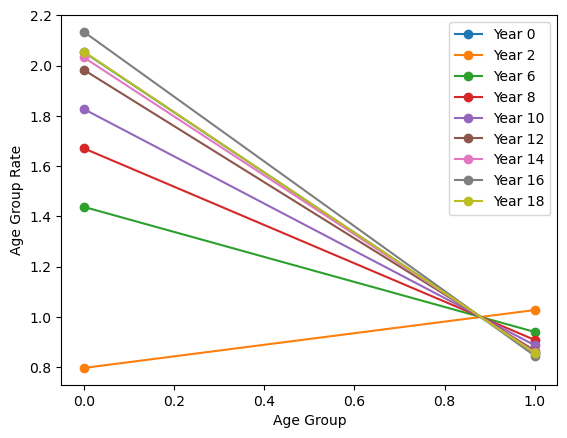

In [43]:
list_lags = list(range(10))
list_lags.remove(2)
for i in list_lags:
    plt.plot([0,1],[prop_0_year[2*i], prop_1_year[2*i]], '-o', label = 'Year '+str(2*i))
plt.legend()
plt.xlabel('Age Group')
plt.ylabel('Age Group Rate')
plt.show()

## Two age groups SIR dynamics with seasonality and stochastic reintroduction

In [59]:
seasons = 20
t_single_season = np.arange(0,365,1) 
t_total_season = np.arange(0,365*20,1)
I_0_season = []
I_1_season = []

beta_0 = 0.0
beta_aug = 10*(1/10.0) # report with 0.5 as well
t_start = 0 
t_season = 60
t_year = 365
prop_imported = 0.05

y0 = alpha, 0.0, 0, 1-alpha-0.1, 0.1, 0

alpha = 0.12
mu_0 = 0.0
gamma = 1/(10.0)
l_0 = 1/(10*365)
nu = (l_0 + mu_0)*(alpha)
mu_1 = (l_0*(alpha))/(1-alpha)

In [60]:
for season in np.arange(seasons):
    ret = odeint(two_groups_seasonal_model, y0, t_single_season, args=(beta_0, beta_aug, t_start, t_season, t_year, mu_0, mu_1, gamma, l_0, nu))
    I_0_season.append(list(ret[:,1]))
    I_1_season.append(list(ret[:,4]))
    y0 = ret[-1,:].copy()
    random_number = max(0,np.random.normal(0.05,0.2))
    print(random_number)
    y0 = modify_initial_condition(y0,random_number)

0
0.20897253355864365
0.11285439890137342
0
0.3334598092953705
0.21144730691571328
0.059098016126219434
0.0033815878031173002
0
0.08990481471172652
0.14368782388912887
0
0.2824408098199059
0
0
0.2579454181785401
0
0.024794082937396975
0
0


In [61]:
I_0_season = [item for sublist in I_0_season for item in sublist]
I_1_season = [item for sublist in I_1_season for item in sublist]

Text(0, 0.5, 'Proportion of population')

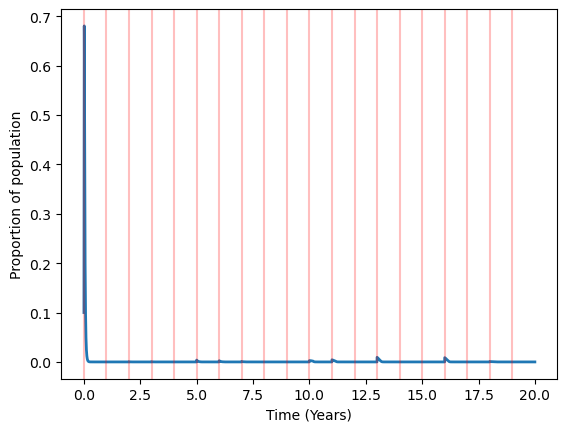

In [62]:
plt.plot(t_total_season/365,np.array(I_0_season) + np.array(I_1_season), linewidth = 2)
for season in np.arange(seasons):
    plt.axvline(season, color = 'r', alpha = 0.25)
plt.xlabel('Time (Years)')
plt.ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

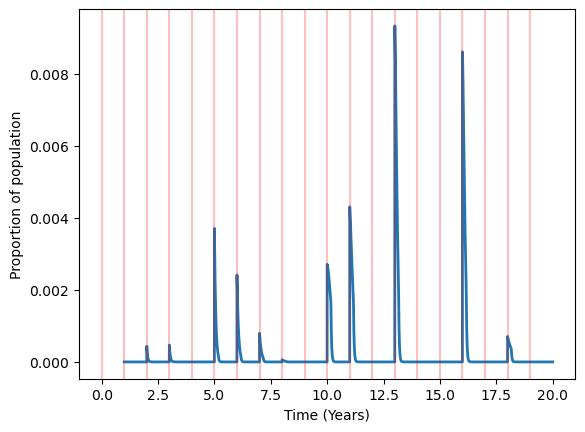

In [64]:
plt.plot(t_total_season[365:]/365,np.array(I_0_season)[365:] + np.array(I_1_season)[365:], linewidth = 2)
for season in np.arange(seasons):
    plt.axvline(season, color = 'r', alpha = 0.25)
plt.xlabel('Time (Years)')
plt.ylabel('Proportion of population')

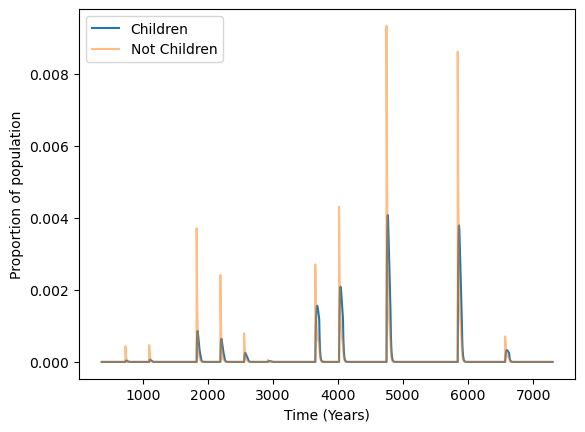

In [66]:
plt.plot(t_total_season[365:],np.array(I_0_season)[365:], label = 'Children')
plt.plot(t_total_season[365:],np.array(I_1_season)[365:], label = 'Not Children',alpha = 0.5)
plt.xlabel('Time (Years)')
plt.ylabel('Proportion of population')
plt.legend()

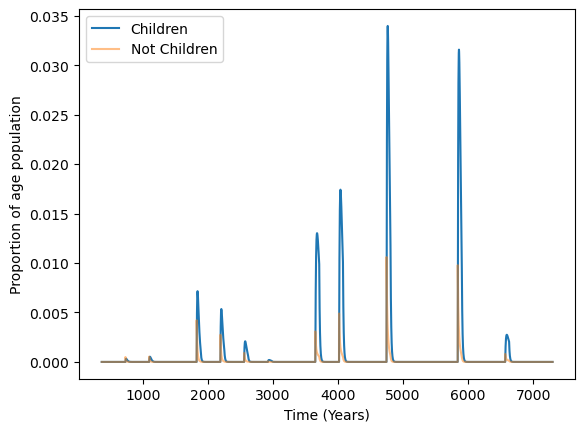

In [67]:
plt.plot(t_total_season[365:],np.array(I_0_season)[365:]/alpha, label = 'Children')
plt.plot(t_total_season[365:],np.array(I_1_season)[365:]/(1-alpha), label = 'Not Children',alpha = 0.5)
plt.xlabel('Time (Years)')
plt.ylabel('Proportion of age population')
plt.legend()

In [68]:
IT = I_0_season + I_1_season
prop_0_year = []
prop_1_year = []

for i in range(20):
    total_cases = sum(I_0_season[i*365:(i+1)*365]) + sum(I_1_season[i*365:(i+1)*365])
    prop_0_year.append(sum(I_0_season[i*365:(i+1)*365])/(alpha*total_cases))
    prop_1_year.append(sum(I_1_season[i*365:(i+1)*365])/((1-alpha)*total_cases))

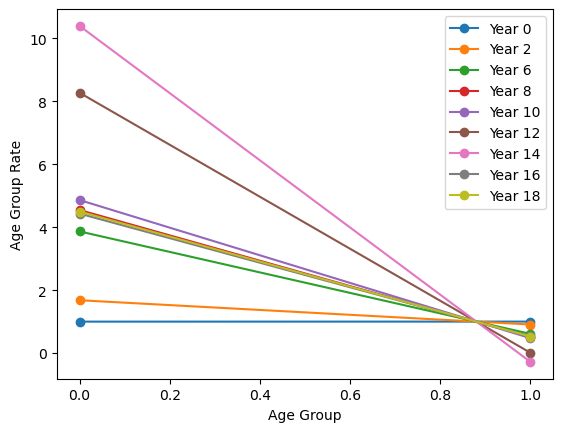

In [70]:
list_lags = list(range(10))
list_lags.remove(2)
for i in list_lags:
    plt.plot([0,1],[prop_0_year[2*i], prop_1_year[2*i]], '-o', label = 'Year '+str(2*i))
plt.legend()
plt.xlabel('Age Group')
plt.ylabel('Age Group Rate')
plt.show()